# Python implementation for Pulse Jitter analysis
Using the psrchive module, we can call psrchive commands in python and use it to analyse raw pulsar data. Our goal is to measure the pulse jitter and see how it varies when we change the frequency channels and integration time.

In [22]:
import os
import psrchive
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean, stdev

## Dedispersing raw data
Dedisperse the raw data and remove the baseline. Save the results to a new fits file.

In [ ]:
raw = psrchive.Archive_load('extra/raw_fits/original_fits.fits')
raw.dedisperse()
raw.remove_baseline()
raw.unload('extra/raw_fits/dedispersed.fits')

Reducing the number of channels from 4096 to 512. This makes calculations on the data faster.

In [ ]:
raw.fscrunch_to_nchan(512)
raw.unload('fits/802_512.fits')

Measuring data dimensions

In [3]:
test = psrchive.Archive_load('fits/802_512.fits')
test_data = test.get_data()
test_data.shape

Unrecognized telescope code (GMRT)


(802, 1, 512, 1024)

Plotting a single pulse from a given subint and channel

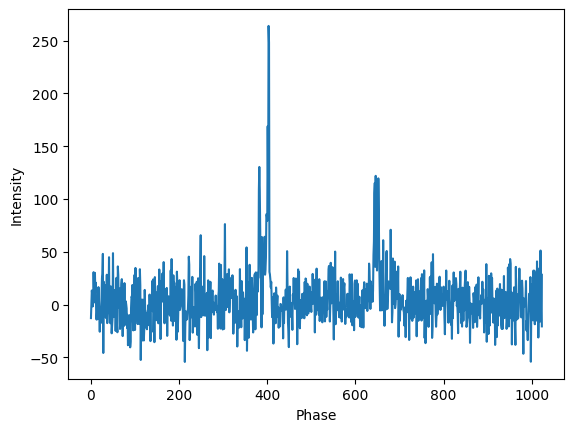

In [4]:
subint = 150
chan = 300  # frequencies are stored in descending order

xvalues = np.arange(1024)
yvalues = test_data[subint,0,chan,:]
plt.xlabel('Phase')
plt.ylabel('Intensity')
plt.plot(xvalues, yvalues)

Plotting SNR for entire data (dspec image)

In [5]:
def snr(data, start=375, end=410):
    on = sum(data[start:end])
    off = stdev(np.concatenate((data[:start], data[end:])))
    return on/off

In [ ]:
subints = test.get_nsubint()
chans = test.get_nchan()

signal_to_noise = np.zeros((chans, subints))

for i in range(subints):
    for j in range(chans):
        signal_to_noise[j][i] = snr(test_data[i,0,j,:])

Text(0, 0.5, 'Frequency (MHz)')

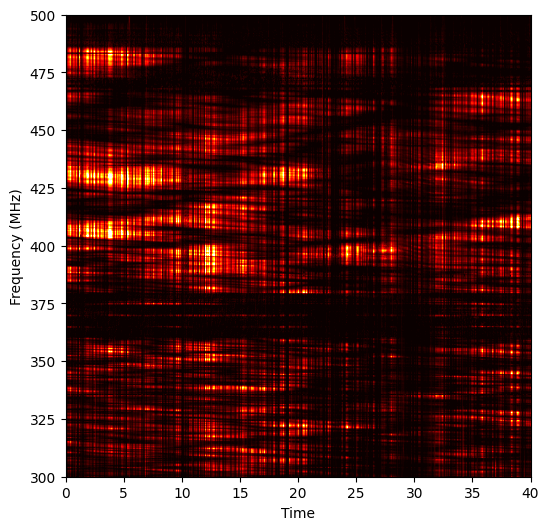

In [104]:
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(signal_to_noise, cmap='hot', extent=[0,40,300,500], aspect='auto', vmin=10, vmax=1000)
ax.set_xlabel("Time")
ax.set_ylabel("Frequency (MHz)")

## Cleaning RFIs
The data obtained is full of RFIs and dead channels. We need to remove these subints and channels to proceed with our analysis.

In [7]:
def snr_data(data, start=375, end=410, plot=False, plot_x=[0,0], xlab=""):
    snr_values = []

    if len(data) > 1:  # Multiple subints, 1 channel
        for i in range(len(data)):
            snr_values.append(snr(data[i,0,0,:], start, end))
    else:  # 1 subint, multiple channels
        for i in range(len(data[0,0])):
            snr_values.append(snr(data[0,0,i,:], start, end))
        snr_values = snr_values[::-1]
    
    if plot:
        if plot_x == [0,0]:
            xvalues = np.arange(len(snr_values))
        else:
            xvalues = np.linspace(plot_x[0], plot_x[1], len(snr_values))
        plt.xlabel(xlab)
        plt.ylabel("SNR")
        plt.plot(xvalues, snr_values)

    return snr_values

Plotting SNR for every subint after collapsing all channels

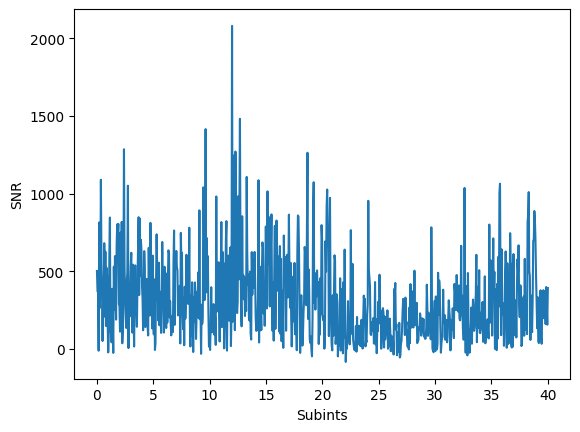

In [8]:
test = psrchive.Archive_load('fits/802_512.fits')
test.fscrunch()
test_data = test.get_data()

x = snr_data(test_data, plot=True, plot_x=[0,40], xlab="Subints")

Plotting SNR for every channel after collapsing all subints

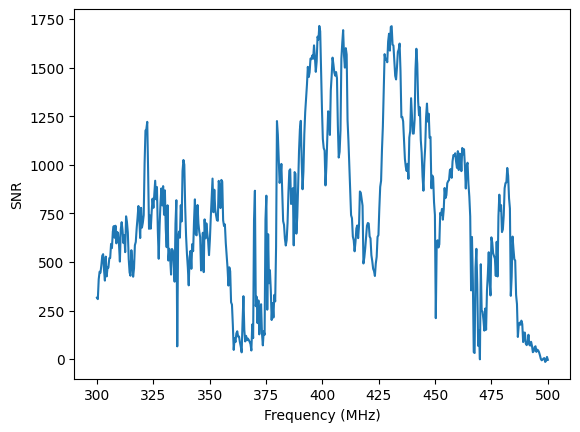

In [9]:
test = psrchive.Archive_load('fits/802_512.fits')
test.tscrunch()
test_data = test.get_data()

x = snr_data(test_data, plot=True, plot_x=[300,500], xlab="Frequency (MHz)")

Clean RFIs by removing channels where the (on-pulse/off-pulse) ratio is below a given threshold

In [10]:
def rficlean(data, threshold, start=375, end=410, plot=False, plot_x=[0,0]):
    rfis = []
    valid = []

    if len(data) > 1:  # Multiple subints, 1 channel
        size = len(data)
        for i in range(len(data)):
            mean_pulse = mean(data[i,0,0,start:end])
            mean_noise = mean(np.absolute(np.concatenate((data[i,0,0,:][:start], data[i,0,0,:][end:]))))
            if mean_pulse/mean_noise < threshold:
                rfis.append(i)
                valid.append(1)
            else:
                valid.append(0)

    else:  # 1 subint, multiple channels
        size = len(data[0,0])
        for i in range(len(data[0,0])):
            mean_pulse = mean(data[0,0,i,start:end])
            mean_noise = mean(np.absolute(np.concatenate((data[0,0,i,:][:start], data[0,0,i,:][end:]))))
            if mean_pulse/mean_noise < threshold:
                rfis.append(i)
                valid.append(1)
            else:
                valid.append(0)
        valid = valid[::-1]

    if plot:
        if plot_x == [0,0]:
            xvalues = np.arange(size)
        else:
            xvalues = np.linspace(plot_x[0], plot_x[1], size)
        plt.plot(xvalues, valid)
  
    return rfis, valid

457


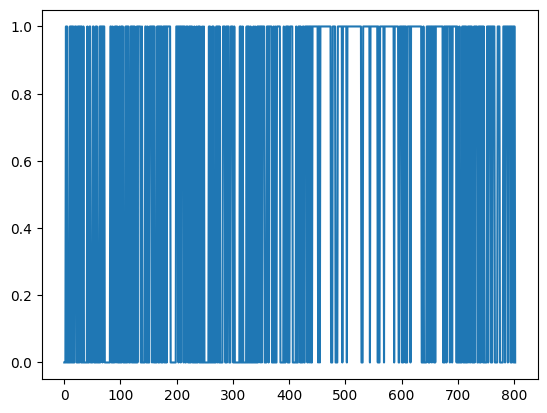

In [24]:
original = psrchive.Archive_load('fits/802_512.fits')
original.fscrunch()
data = original.get_data()

rfi, valid = rficlean(data, threshold=10, plot=True, plot_x=[0,802])
print(len(rfi))

In [25]:
original = psrchive.Archive_load('fits/802_512.fits')
for i in range(len(rfi)):
    original.erase(rfi[len(rfi)-i-1])
original.unload("trial.fits")

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 70, 72, 73, 75, 77, 78, 79, 83, 84, 127, 309, 310, 311, 312, 313, 314, 318, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 420]


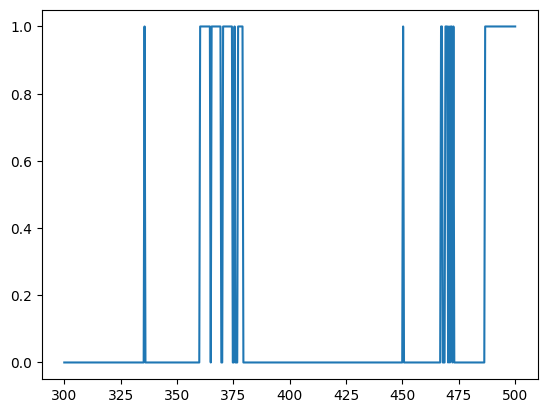

In [26]:
original = psrchive.Archive_load('trial.fits')
original.tscrunch()
data = original.get_data()

rfi, valid = rficlean(data, threshold=15, plot=True, plot_x=[300,500])
print(rfi)

In [27]:
chans = " ".join(str(rfi[i]) for i in range(len(rfi)))
! paz -e tt -z "{chans}" trial.fits
! pam -e tt -TF trial.tt
! psrsmooth -W trial.tt
os.rename("trial.tt.sm", "template.fits")

Unrecognized telescope code (GMRT)
ProcHistory::set_command_str WARNING truncated to 256 chars
Unloading trial.tt ... done
Unrecognized telescope code (GMRT)
trial.tt written to disk
Unrecognized telescope code (GMRT)


In [111]:
# original = psrchive.Archive_load('trial.fits')
# x = original.get_centre_frequency()
# for i in range(len(rfi)):
#     original.remove_chan(rfi[len(rfi)-i-1], rfi[len(rfi)-i-1])

# original.set_centre_frequency(x)
# original.unload('trial2.fits')